# GP2GP Failure Rate - Oct 2020

Context:
- PCSE wants the rate of paper transfers being triggered over the last three months.
- Finding the totals and rates of failures involves calculating, for each month:
    - the total number of transfers
    - the total number of successful transfers completed within 8 days SLA 
    - the total number of successful transfers completed beyond 8 days SLA
    - the total remaining number of transfers assumed unsuccessful

Assumptions:
- We define the failure rate as a transfer without a successful final ack, an incorrect message sequence or not within the 8 day SLA.
- We are aware that there are transfers where a message could contain a placeholder (therefore triggering the paper process), however since this metadata is not provided in the Spine logs, we can not identify these failures and they will be classified as complete.

Requirements:
- This notebook uses the following Splunk query:
```
index="spine2vfmmonitor" service="gp2gp"
| search interactionID="urn:nhs:names:services:gp2gp/*"
| rex field=fromPartyID "(?<fromNACS>.+)(-\d*)"
| rex field=toPartyID "(?<toNACS>.+)(-\d*)"
| fields _time, conversationID, GUID, interactionID, fromNACS, toNACS, messageRef, jdiEvent
| fields - _raw
```

In [41]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from gp2gp.spine.models import COMMON_POINT_TO_POINT, EHR_REQUEST_COMPLETED
from sys import argv
from gp2gp.io.csv import read_gzip_csv_files
from gp2gp.spine.sources import construct_messages_from_splunk_items
from gp2gp.spine.transformers import (
    group_into_conversations,
    parse_conversation,
    filter_conversations_by_request_started_time,
    ConversationMissingStart,
)
from gp2gp.service.transformers import (
    derive_transfers,
    filter_for_successful_transfers,
    calculate_sla_by_practice,
)
from gp2gp.service.models import (
    SlaBand,
)
from gp2gp.pipeline.dashboard.core import (
    _parse_conversations
)
from gp2gp.pipeline.dashboard.main import (
    read_spine_csv_gz_files
)

from gp2gp.date.range import DateTimeRange
from datetime import datetime
from dateutil.tz import UTC
from dateutil.relativedelta import relativedelta

In [3]:
def calculate_date_range(year, month):
    metric_month = datetime(year, month, 1, tzinfo=UTC)
    next_month = metric_month + relativedelta(months=1)
    time_range = DateTimeRange(metric_month, next_month)
    return time_range   

In [4]:
EIGHT_DAYS_IN_SECONDS = 691200

def assign_to_sla(sla_duration):
    sla_duration_in_seconds = sla_duration.total_seconds()
    if sla_duration_in_seconds <= EIGHT_DAYS_IN_SECONDS:
        return SlaBand.WITHIN_8_DAYS
    else:
        return SlaBand.BEYOND_8_DAYS


In [5]:
def calculate_sla(transfers):
    default_sla = {SlaBand.WITHIN_8_DAYS: 0, SlaBand.BEYOND_8_DAYS: 0}
    for transfer in transfers:
        if transfer.sla_duration is not None:
            sla_band = assign_to_sla(transfer.sla_duration)
            default_sla[sla_band] += 1
    return default_sla

In [6]:
def spine_data_transformer(main_month_data, next_month_data, year, month):
    spine_messages = read_spine_csv_gz_files([main_month_data, next_month_data])
    conversations = group_into_conversations(spine_messages)
    parsed_conversations = _parse_conversations(conversations)
    time_range = calculate_date_range(year, month)
    conversations_started_in_range = filter_conversations_by_request_started_time(
        parsed_conversations, time_range
    )
    return conversations_started_in_range

In [7]:
def calculate_gp2gp_failure_metrics(conversations_started_in_range):
    # Service transformers
    transfers = derive_transfers(conversations_started_in_range)
    alltransfers = list(transfers)
    completed_transfers = filter_for_successful_transfers(iter(alltransfers))
    allcompleted = list(completed_transfers)
    slas = calculate_sla(allcompleted)

    # Counts
    transfer_count = len(alltransfers)
    success_count = slas[SlaBand.WITHIN_8_DAYS]
    failed_count = len(alltransfers)-success_count
    completed_count = len(allcompleted)

    # Rates
    failure_rate = (failed_count/transfer_count)*100
    beyond_8day_sla_rate = (slas[SlaBand.BEYOND_8_DAYS]/transfer_count)*100
    not_completed_rate = 100-(completed_count/transfer_count)*100

    if abs(((failed_count/transfer_count)*100) - (beyond_8day_sla_rate+not_completed_rate)) > 0.001:
        print(((failed_count/transfer_count)*100)-(beyond_8day_sla_rate+not_completed_rate))
        print("Error: Failure rate not equal to beyond_8_day plus not_completed")

    return {"total_transfers": transfer_count, 
            "total_completed": completed_count,
            "total_within_8_day_sla": slas[SlaBand.WITHIN_8_DAYS], 
            "total_beyond_8_day_sla": slas[SlaBand.BEYOND_8_DAYS], 
            "percent_not_completed": not_completed_rate,
            "percent_completed_beyond_8_day_sla": beyond_8day_sla_rate,
            "percent_triggering_paper_transfer": not_completed_rate+beyond_8day_sla_rate
            }

In [8]:
july_data_file_name="../data/months/July-2020.csv.gz"
august_data_file_name="../data/months/Aug-2020.csv.gz"
september_data_file_name = "../data/months/Sept-2020.csv.gz"
october_data_file_name = "../data/months/Oct-2020.csv.gz"

july_conversations_started_in_range = spine_data_transformer(july_data_file_name, august_data_file_name, 2020, 7)
august_conversations_started_in_range = spine_data_transformer(august_data_file_name, september_data_file_name, 2020, 8)
sept_conversations_started_in_range = spine_data_transformer(september_data_file_name, october_data_file_name, 2020, 9)

In [9]:
july_result = calculate_gp2gp_failure_metrics(july_conversations_started_in_range)
print(f"JULY: {july_result}")

JULY: {'total_transfers': 165069, 'total_completed': 150949, 'total_within_8_day_sla': 142996, 'total_beyond_8_day_sla': 7953, 'percent_not_completed': 8.553998630875569, 'percent_completed_beyond_8_day_sla': 4.817985206186504, 'percent_triggering_paper_transfer': 13.371983837062071}


In [10]:
aug_result = calculate_gp2gp_failure_metrics(august_conversations_started_in_range)
print(f"AUGUST: {aug_result}")

AUGUST: {'total_transfers': 165620, 'total_completed': 151702, 'total_within_8_day_sla': 141470, 'total_beyond_8_day_sla': 10232, 'percent_not_completed': 8.403574447530488, 'percent_completed_beyond_8_day_sla': 6.177997826349475, 'percent_triggering_paper_transfer': 14.581572273879964}


In [11]:
sept_result = calculate_gp2gp_failure_metrics(sept_conversations_started_in_range)
print(f"SEPTEMBER: {sept_result}")

SEPTEMBER: {'total_transfers': 273665, 'total_completed': 250329, 'total_within_8_day_sla': 234641, 'total_beyond_8_day_sla': 15688, 'percent_not_completed': 8.527213929439284, 'percent_completed_beyond_8_day_sla': 5.73255622750443, 'percent_triggering_paper_transfer': 14.259770156943715}


In [33]:
failure_rates_df = pd.DataFrame.from_dict([july_result, aug_result, sept_result])
failure_rates_df["months"] = ["July", "August", "September"]
failure_rates_df = failure_rates_df.set_index("months")
failure_rates_df

,total_transfers,total_completed,total_within_8_day_sla,total_beyond_8_day_sla,percent_not_completed,percent_completed_beyond_8_day_sla,percent_triggering_paper_transfer
months,,,,,,,
July,165069,150949,142996,7953,8.553999,4.817985,13.371984
August,165620,151702,141470,10232,8.403574,6.177998,14.581572
September,273665,250329,234641,15688,8.527214,5.732556,14.259770


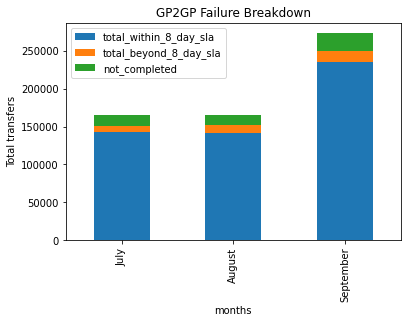

In [45]:
failure_rates_subset_df = failure_rates_df[["total_within_8_day_sla", "total_beyond_8_day_sla"]]
failure_rates_subset_df["not_completed"] = failure_rates_df["total_transfers"]-failure_rates_df["total_completed"]
failure_rates_subset_df
failure_rates_subset_df.plot(kind="bar", stacked=True)
plt.title("GP2GP Failure Breakdown")
plt.ylabel("Total transfers")
plt.show()